In [1]:
import dropbox
from dropbox import DropboxOAuth2FlowNoRedirect
import os
from io import BytesIO
import time
import numpy as np
import matplotlib.pyplot as plt

# APP_KEY = "qi3onmgezlr00yv"
# auth_flow = DropboxOAuth2FlowNoRedirect(APP_KEY, use_pkce=True, token_access_type='offline')

# authorize_url = auth_flow.start()
# print("1. Go to: " + authorize_url)
# print("2. Click \"Allow\" (you might have to log in first).")
# print("3. Copy the authorization code.")
# auth_code = input("Enter the authorization code here: ").strip()

# try:
#     oauth_result = auth_flow.finish(auth_code)
# except Exception as e:
#     print('Error: %s' % (e,))
#     exit(1)

# with dropbox.Dropbox(oauth2_refresh_token=oauth_result.refresh_token, app_key=APP_KEY) as dbx:
#     dbx.users_get_current_account()
#     print("Successfully set up client!")

In [3]:
# print(oauth_result.refresh_token)

b_N3-an_VvQAAAAAAAAAAc7kTAMBxeYC9GlsLpwgFrXX3kbZr2li3f3GfGx-iGnr


In [2]:
APP_KEY = 'qi3onmgezlr00yv'
REFRESH_TOKEN = 'b_N3-an_VvQAAAAAAAAAAc7kTAMBxeYC9GlsLpwgFrXX3kbZr2li3f3GfGx-iGnr'

def get_access_token():
    dbx = dropbox.Dropbox(oauth2_refresh_token=REFRESH_TOKEN, app_key=APP_KEY)
    return dbx

def load_npy_from_dropbox(file_path):
    dbx = get_access_token()
    
    try:
        metadata, res = dbx.files_download(file_path)
        file_stream = BytesIO(res.content)
        np_array = np.load(file_stream)
        
        return np_array

    except dropbox.exceptions.ApiError as err:
        print(f'Error: {err}')
        return None

In [3]:
def crop(img, crop_size=320):
    height, width = img.shape[-2:]
    w_from = (width - crop_size) // 2
    w_to = w_from + crop_size
    h_from = (height - crop_size) // 2
    h_to = h_from + crop_size

    return img[:, :, h_from:h_to, w_from:w_to]

def rss_coil_combine(image):
    squared_abs = np.abs(image)**2
    sum_of_squares = np.sum(squared_abs, axis=1)
    combined_images = np.sqrt(sum_of_squares)
    return combined_images

def normal_in_i(image):
    mean = np.mean(image)
    std = np.std(image)
    tmp = (image - mean) / (std + 1e-10)
    return tmp

In [5]:
def dropbox_connect():
    dbx = dropbox.Dropbox(oauth2_refresh_token=REFRESH_TOKEN, app_key=APP_KEY)
    return dbx

def download_npy_file(dbx, dropbox_path, max_retries=3, delay=5):
    for attempt in range(max_retries):
        try:
            print(f"Downloading {dropbox_path}, attempt {attempt + 1}")
            _, response = dbx.files_download(dropbox_path)
            file_data = response.content
            npy_data = np.load(BytesIO(file_data))  
            return npy_data
        except Exception as e:
            print(f"Error downloading {dropbox_path}: {e}")
            if attempt + 1 == max_retries:
                print(f"Max retries reached for {dropbox_path}")
                return None
            else:
                print(f"Retrying in {delay} seconds...")
                time.sleep(delay)  

def load_npy_from_dropbox(dbx, folder_path):
    imgdata = []
    try:
        folder_metadata = dbx.files_list_folder(folder_path)
        for entry in folder_metadata.entries:
            if isinstance(entry, dropbox.files.FileMetadata) and entry.name.endswith('.npy'):
                file_path = os.path.join(folder_path, entry.name)
                volume = download_npy_file(dbx, file_path)
                if volume is not None:
                    volume = rss_coil_combine(volume)
                    for i in range(volume.shape[0]):
                        volume[i, :, :] = normal_in_i(volume[i, :, :])
                    imgdata.append(volume)
                    
    except Exception as e:
        print(f"Error accessing folder {folder_path}: {e}")
    return imgdata


In [6]:
if __name__ == "__main__":
    dbx = dropbox_connect()
    dropbox_folder_path = '/Motion_data_whole_notrans_flair_0922'
    # dropbox_folder_path = 'Motion_data_whole_notrans_t1post_0922'
    # dropbox_folder_path = '/Motion_data_whole_notrans_t2_0922'
    npy_data = load_npy_from_dropbox(dbx, dropbox_folder_path)
    print(f"Loaded {len(npy_data)} npy files.")

Loaded 163 npy files.


In [7]:
from skimage.transform import rotate

def rotate_image(image):
    h, w = image.shape
    center_h, center_w = h // 2, w // 2
    brain_region = image[center_h - 160:center_h + 160, center_w - 160:center_w + 160]

    rotated_brain = rotate(brain_region, 270, resize=False)  
    rotated_image = np.copy(image)
    rotated_image[center_h - 160:center_h + 160, center_w - 160:center_w + 160] = rotated_brain

    return rotated_image

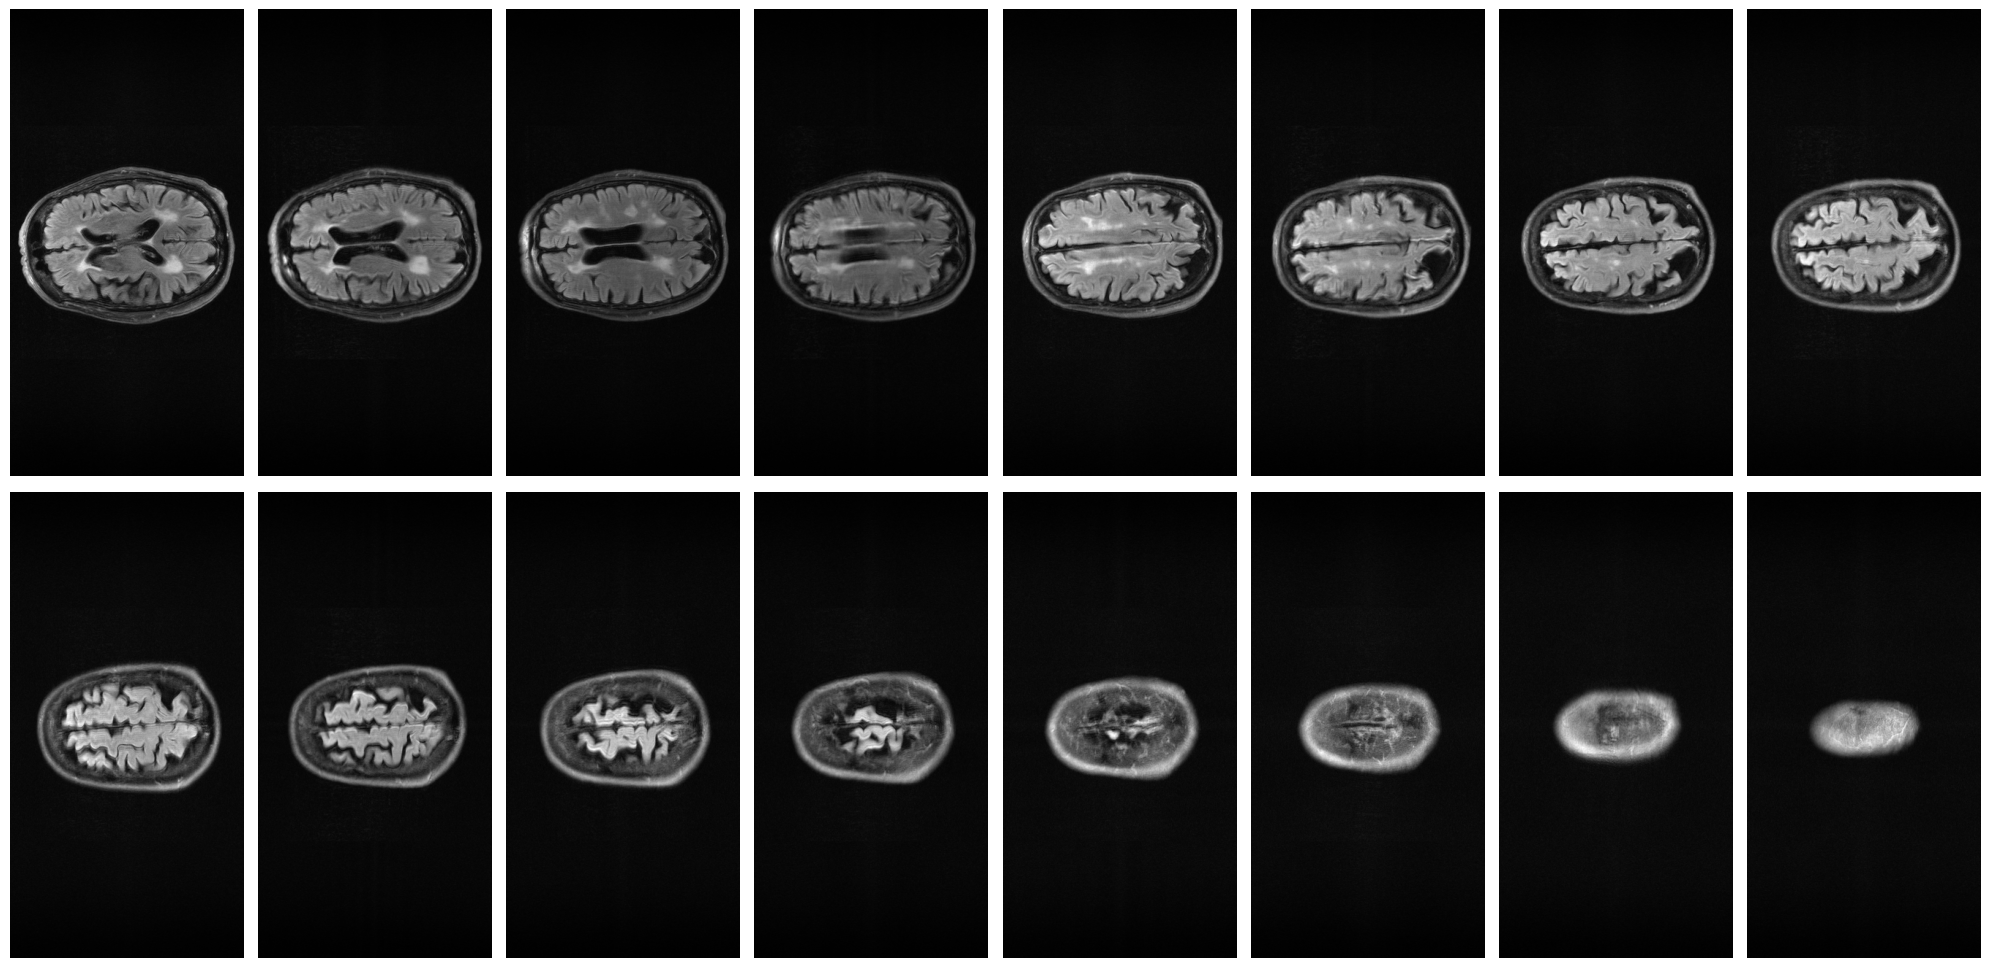

In [8]:
volume = npy_data[4]

for i in range(volume.shape[0]):
    volume[i] = rotate_image(volume[i])

plt.figure(figsize=(20, 10))  
for i in range(len(volume)):
    plt.subplot(2, 8, i+1)
    plt.imshow(volume[i], cmap='gray', origin='lower')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
npy_data[4] = volume

In [ ]:
for volume in npy_data:
    plt.figure(figsize=(20, 10))  
    for i in range(len(volume)):
        plt.subplot(2, 8, i+1)
        plt.imshow(volume[i], cmap='gray', origin='lower')
        plt.axis('off')
    plt.tight_layout()
    plt.show()